In [1]:
from pathlib import Path
import numpy as np
np.random.seed(42)  # answer to life and the universe

In [2]:
from fastai.vision.all import *

In [3]:
def label_func(x):
    """ we will use the parent folder name as the label"""
    return x.parent.name

In [4]:
import PIL

In [5]:
import torch
from torchvision.transforms import functional as F

In [6]:
train_path = Path('./Dataset/Training/')
validation_path = Path('./Dataset/Validation/')

In [7]:
files = get_image_files(train_path)
files.extend(get_image_files(validation_path))

In [8]:
len(files)

1920

In [8]:
data = ImageDataLoaders.from_path_func(
        path='.',
        fnames=files,
        label_func=label_func,
        valid_pct=0.3,
        seed=42,
        item_tfms=Resize(224),
        num_workers=0,  # due to pytorch and windows issues
        bs=16,  # my system failed above this size
    )

In [10]:
data.vocab

['Bicycle', 'Boat', 'Cat', 'Motorbike', 'People', 'Table']

In [9]:
learner = cnn_learner(
        data,
        densenet201,
        #alexnet, #trying alex, densenet didnt seem to work properly
        pretrained=True,
        metrics=accuracy,
        #memory_efficient=True,
    ).to_fp16()

c:\users\chakr\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [18]:
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.455785,0.708734,0.777778,00:41


SuggestedLRs(minimum=3.981071640737355e-05, steep=4.786300905834651e-06, valley=0.0003311311302240938, slide=0.00013182566908653826)

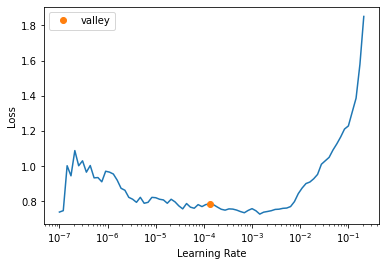

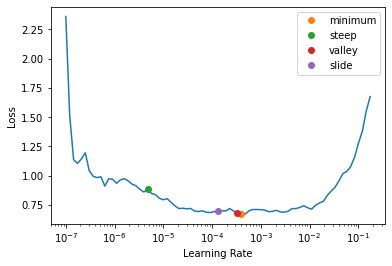

In [21]:
learner.lr_find()
learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [22]:
learner.unfreeze()

In [17]:
save_best_model = SaveModelCallback(monitor='accuracy')

In [27]:
learner.fit_one_cycle(30, lr_max=slice(1e-5, 1e-3), cbs=[save_best_model])

epoch,train_loss,valid_loss,accuracy,time
0,0.265632,0.608489,0.836806,00:43
1,0.205692,0.630862,0.835069,00:43
2,0.202737,0.652410,0.840278,00:43
3,0.235231,0.719383,0.824653,00:43
4,0.304504,0.857560,0.802083,00:43
5,0.330411,0.932849,0.776042,00:43
6,0.330744,0.867608,0.807292,00:43
7,0.271721,0.824178,0.824653,00:43
8,0.249094,0.805127,0.815972,00:43
9,0.194136,0.764094,0.829861,00:43


Better model found at epoch 0 with accuracy value: 0.8368055820465088.
Better model found at epoch 2 with accuracy value: 0.8402777910232544.
Better model found at epoch 12 with accuracy value: 0.8472222089767456.
Better model found at epoch 22 with accuracy value: 0.8541666865348816.
Better model found at epoch 23 with accuracy value: 0.8559027910232544.
Better model found at epoch 24 with accuracy value: 0.8611111044883728.


In [28]:
learner.save('trained')

Path('models/trained.pth')

In [10]:
# to load the model, learner.load('trained')
learner.load('trained')
interp = ClassificationInterpretation.from_learner(learner)

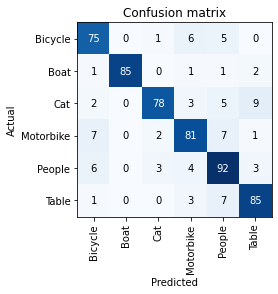

In [30]:
interp.plot_confusion_matrix()

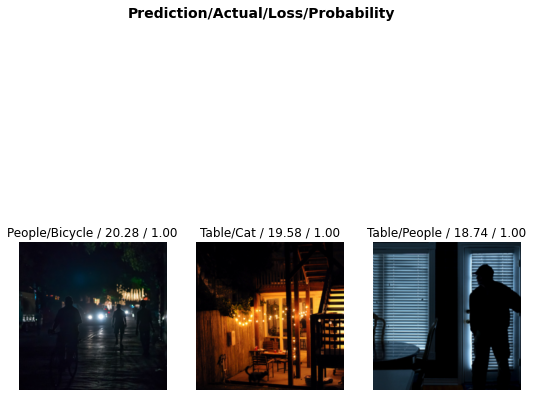

In [31]:
interp.plot_top_losses(3, figsize=(9,9))

In [11]:
test_csv = './AI_Basic_Test/test_set.csv'

In [13]:
with open(test_csv, 'r') as reader:
    lines = reader.readlines()

In [14]:
lines = lines[1:]

In [15]:
test_path = './Dataset/'

In [16]:
submit_csv = './submit.csv'

In [17]:
import os        

In [18]:
for line in lines:
        line = line[:-2]
        target = os.path.join(test_path, line)
        if not os.path.exists(target):
            print('{} doesnot exist!'.format(target))

In [19]:
with open(submit_csv, 'w') as writer:
    writer.write('File_Path,Class\n')
    for line in lines:
        line = line[:-2]
        target = os.path.join(test_path, line)
        pred, _, _ = learner.predict(target)
        target_string = line + ',' + pred + '\n'
        writer.write(target_string)